In [1]:
#!/usr/bin/env python

# ARM_simulation_domains.ipynb

In [2]:
''' 
   ARM_simulation_domains.ipynb

   This program reads in the constant fields from the ARM MCS simulations
   on the large domain in the Southern Great Plains and the Amazon site
   
   It plots the orography, domain location, and ARM site location on two maps

'''

' \n   ARM_simulation_domains.ipynb\n\n   This program reads in the constant fields from the ARM MCS simulations\n   on the large domain in the Southern Great Plains and the Amazon site\n   \n   It plots the orography, domain location, and ARM site location on two maps\n\n'

In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
import math
import matplotlib.patches as patches
import pylab
import netCDF4
import h5py


In [3]:
SGP_File = '/glade/campaign/mmm/c3we/mingge/WRFV4.1.5_intel_dmpar/Thomson_YSU/sgp_20120531_04:00:00_L4/wrfout_d01_2012-05-30_04:00:00'
MAO_File = '/glade/campaign/mmm/c3we/mingge/WRFV4.1.5_intel_dmpar/Thomson_YSU/mao_20150303_20:00:00_L4/wrfout_d01_2015-03-02_20:00:00'
Outfile = '/glade/u/home/prein/papers/2021_ASR_Optimal_Location/plots/domains/ARM_simulation_domains.pdf'

### Load color maps

In [31]:
# from
# https://stackoverflow.com/questions/40895021/python-equivalent-for-matlabs-demcmap-elevation-appropriate-colormap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Combine the lower and upper range of the terrain colormap with a gap in the middle
# to let the coastline appear more prominently.
# inspired by https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 56))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))
# combine them and build a new colormap
colors = np.vstack((colors_undersea, colors_land))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors)


### Read the data and plot them on maps

Figure saved to: /glade/u/home/prein/papers/2021_ASR_Optimal_Location/plots/domains/ARM_simulation_domains.pdf


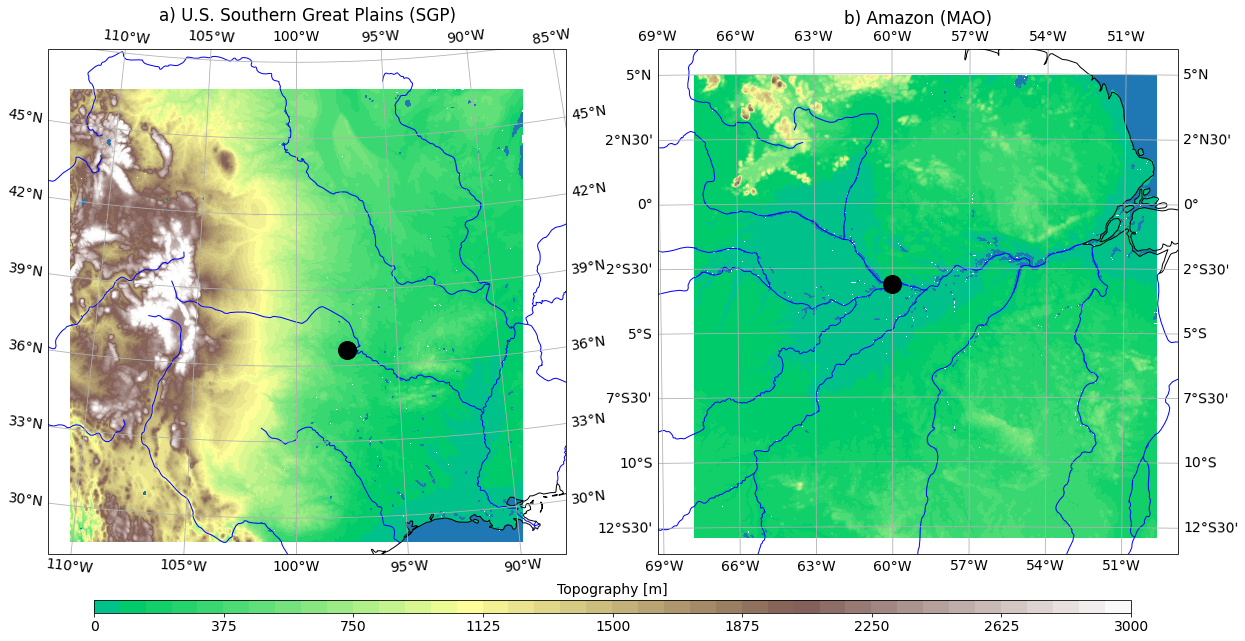

In [102]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cfeature
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

fig = plt.figure(figsize=(18,9))
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.04, right=0.96,
   bottom=0.15, top=0.93,
   wspace=0.05, hspace=0.35)
plt.rcParams.update({'font.size': 14})
# m = Basemap(llcrnrlon=-100.,llcrnrlat=-55.,urcrnrlon=-35,urcrnrlat=17.75,
#                   projection='lcc', lat_1=-40. ,lat_2=-5.,lat_0=-22.00002,lon_0=-58.)

for re in range(2):
    if re == 0:
        REGION = 'b) Amazon (MAO)'
        proj = ccrs.LambertConformal(central_longitude=-58.70001, central_latitude=-4.00003, false_easting=0.0, false_northing=-2, secant_latitudes=None, standard_parallels=None, globe=None)
        FILE = MAO_File
        ncfile = Dataset(FILE)
        HGT = getvar(ncfile, "HGT")
        proj = get_cartopy(HGT)
        ax = plt.subplot(gs1[0,1], projection=proj)
#         ax = plt.axes(projection=proj)
        ax.set_extent([-69, -49, -13.5,6], ccrs.Geodetic())
        ARMlon = -60.025
        ARMlat = -3.113
    if re == 1:
        REGION = 'a) U.S. Southern Great Plains (SGP)'
        proj = ccrs.LambertConformal(central_longitude=-100., central_latitude=38) #, false_easting=0.0, false_northing=0.0, secant_latitudes=None, standard_parallels=None, globe=None)
        FILE = SGP_File
        ncfile = Dataset(FILE)
        HGT = getvar(ncfile, "HGT")
        proj = get_cartopy(HGT)
        ax = plt.subplot(gs1[0,0], projection=proj)
        ax.set_extent([-111, -88, 28, 48], ccrs.Geodetic())
        ARMlon = -97.4882
        ARMlat = 36.6077
    
    # read the netcdf data
    ncid=Dataset(FILE, mode='r')
    Lat=np.squeeze(ncid.variables['XLAT'][:])
    Lon=np.squeeze(ncid.variables['XLONG'][:])
    HGT = np.squeeze(ncid.variables['HGT'][:])
    LSM = np.squeeze(ncid.variables['LANDMASK'][:])
    LAKE_Mask = np.squeeze(ncid.variables['LAKEMASK'][:])
    ncid.close()
    
    SEA = (LSM < 0.5) | (LAKE_Mask > 0.5)
    HGT[SEA] = np.nan
    SEA = np.array(SEA).astype(float)
    SEA[SEA == 0] = np.nan
    
    norm = FixPointNormalize(sealevel=0, vmax=3000)
    cs = plt.contourf(Lon,Lat,HGT, transform=ccrs.PlateCarree(), norm=norm, cmap=plt.cm.terrain, levels=np.linspace(0,3000,41))
    css = ax.contourf(Lon,Lat, SEA, transform=ccrs.PlateCarree(), colors=['#1f78b4','#1f78b4'], levels=[0.9,1.1])

    ax.coastlines()
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    # plot ARM location
    ax.plot(ARMlon,ARMlat,'ko', transform=ccrs.PlateCarree(), markersize=18)
    
    plt.title(REGION)
    
    
CbarAx = axes([0.10, 0.06, 0.8, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=clevs)
cb.ax.set_title('Topography [m]', fontsize=14)
fig.savefig(Outfile)
print('Figure saved to: '+Outfile)